In [1]:
import anndata as ad
import networkx as nx
import numpy as np
import pandas as pd
import scglue
import seaborn as sns
from IPython import display
from matplotlib import rcParams
from networkx.algorithms.bipartite import biadjacency_matrix
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv
import matplotlib.pyplot as plt

In [2]:
draft_grn = pd.read_csv('draft_grn_m.csv')

In [3]:
draft_grn_ge10 = draft_grn.loc[draft_grn['importance'] > 10]

In [4]:
PG = nx.from_pandas_edgelist(draft_grn_ge10, 
                            source='TF', 
                            target='target', 
                            edge_attr='importance', 
                            create_using=nx.DiGraph())

In [5]:
count = draft_grn_ge10['TF'].value_counts()
#count_dict = count.to_dict()
counts = count.to_frame()
counts.rename(columns={'': 'TF', 'TF': 'count'})
#counts['TF'] = list(counts.index)
counts = count.to_frame().reset_index()
counts.rename(columns={'index': 'TF', 'TF': 'count'}, inplace=True)
top_10_tfs = counts[0:10]

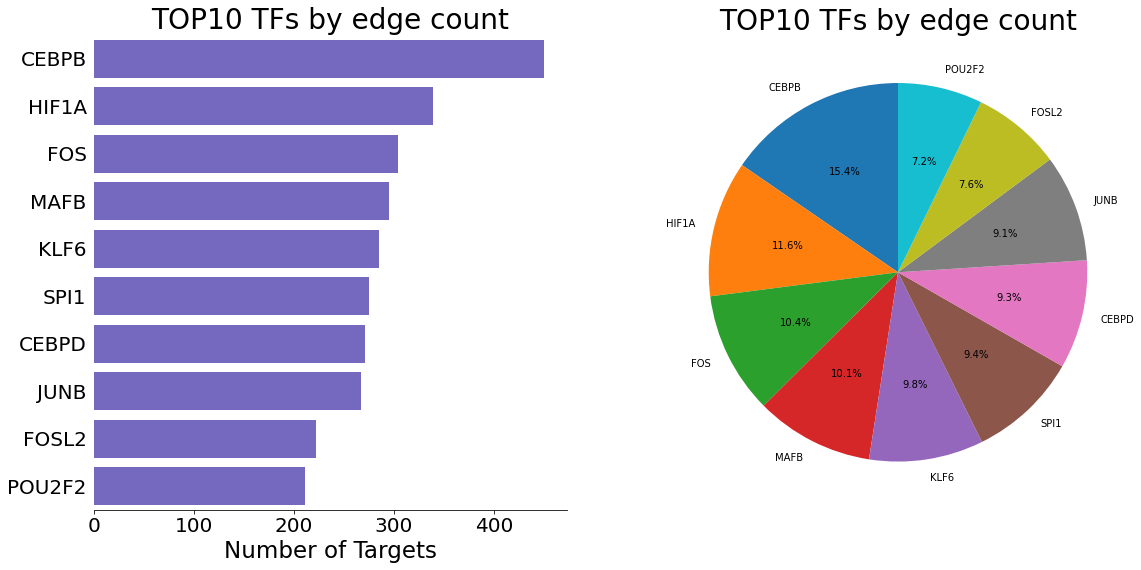

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
fig, ax = plt.subplots(figsize=(16,8))
fig.tight_layout(pad=4)
# Creating a case-specific function to avoid code repetition
# (will be used for comparing with 2 more plot types)
def plot_hor_bar_2():
    ax = sns.barplot(x='count', y='TF',
                     data=top_10_tfs, color='slateblue')
    plt.title('TOP10 TFs by edge count', fontsize=28)
    plt.xlabel('Number of Targets', fontsize=23)
    plt.xticks(fontsize=20)
    plt.ylabel(None)
    plt.yticks(fontsize=20)
    sns.despine(left=True)
    ax.grid(False)
    ax.tick_params(bottom=True, left=False)
    return None
plt.subplot(1,2,1)
plot_hor_bar_2()
plt.subplot(1,2,2)
plt.pie(top_10_tfs['count'],
        labels=top_10_tfs['TF'],
        startangle=90, autopct='%1.1f%%')
plt.title('TOP10 TFs by edge count', fontsize=28)
matplotlib.rcParams['font.size']=18
plt.show()

In [7]:
tfs = draft_grn['TF'].value_counts().to_dict().keys()

In [8]:
draft_grn.loc[(draft_grn['TF'] == 'CREM') & (draft_grn['target'] ==  'AREG'), 'importance'].values[0]

11.779217055745091

In [9]:
dtfs = list(draft_grn['TF'])
targets = list(draft_grn['target'])

In [12]:
%%script false --no-raise-error
for node1, node2, data in grn.edges(data=True):
    print(data['weight'])
#nx.get_edge_attributes(grn, weight)
#draft_grn['target']

## Get genes of interest for three patient groups. 

In [11]:
def mean_nested_dict(nested_dict):
    summary = dict()
    for key, subdict in nested_dict.items():
        for k, v in subdict.items():
            summary[k] = summary.get(k, 0) + v
    mean = dict()
    for k,v  in summary.items():
        mean[k]= float(v/len(nested_dict))
    return(mean)

In [15]:
mvsc_file = open("goi_mvsc_frq.txt", "r")
mvsc_lines = mvsc_file.readlines()
goi_mvsc = [gene.strip() for gene in mvsc_lines]
mvsc_file.close()
pageRank_mvsc = dict()
    
for gene in goi_mvsc:
    if gene in PG.nodes: 
        pageRank_mvsc[gene] = nx.pagerank(
            PG.reverse(), 
            personalization={gene: 1})
    else:
        continue
#print(len(pageRank_mvsc))
pageRank_mvsc_mean = mean_nested_dict(pageRank_mvsc) #dict()

In [12]:
avsc_file = open("goi_avsc_frq.txt", "r")
avsc_lines = avsc_file.readlines()
goi_avsc = [gene.strip() for gene in avsc_lines]
avsc_file.close()
pageRank_avsc = dict()
for gene in goi_avsc:
    if gene in PG.nodes: 
        pageRank_avsc[gene] = nx.pagerank(
            PG.reverse(), 
            personalization={gene: 1})
    else:
        continue

pageRank_avsc_mean = mean_nested_dict(pageRank_avsc)#dict()

In [13]:
svsc_file = open("goi_svsc_frq.txt", "r")
svsc_lines = svsc_file.readlines()
goi_svsc = [gene.strip() for gene in svsc_lines]
svsc_file.close()
pageRank_svsc = dict()
for gene in goi_svsc:
    if gene in PG.nodes: 
        pageRank_svsc[gene] = nx.pagerank(
            PG.reverse(), 
            personalization={gene: 1})
    else:
        continue
#print(len(pageRank_svsc))
pageRank_svsc_mean = mean_nested_dict(pageRank_svsc) # dict()

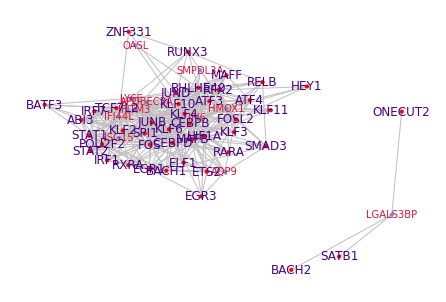

In [16]:
import math
def goi_node_neighbors(network, gene_list, tf_list):
    node_list = []
    for gene in gene_list:
        if gene in network.nodes:
            lst = list(network.reverse().neighbors(gene))+ [gene]
            node_list = node_list + lst
        else:
            continue
    node_list = list(dict.fromkeys(node_list))        
    pre_network = network.subgraph(node_list)
    sub_network = nx.Graph(pre_network)
    sub_network.remove_nodes_from(list(nx.isolates(sub_network)))
    #non_tfs = [i for i in sub_net.nodes if i not in tf_list]
    return(sub_network)
    
def format_network_parameters(network, tf_list, goi_list):
    #dpos = graphviz_layout(nx.DiGraph.reverse(network))#, prog="dot", root=1000,
    #args='-Gsplines=true -Gnodesep=0.6 -Goverlap=scalexy')
    dpos = nx.spring_layout(network, k=0.6, iterations=60) #scale=2)
    #dpos = nx.nx_agraph.graphviz_layout(network, prog="twopi", args="")
    #dpos = nx.nx_agraph.graphviz_layout(network, prog="twopi", root=0)
    # generate positions for labels
    nodes_small_font = []
    nodes_large_font = []
    net_start = []
    for i in network.nodes:
        if i not in tf_list:nodes_small_font.append(i)
        elif i in tf_list:nodes_large_font.append(i)
        elif i in goi_list:net_start.append(i)
            
    pre_weight = list(nx.get_edge_attributes(network, 'importance').values())
    weights = [round(math.log2(i),1) for i in pre_weight]
    
    color = []
    for  i in network.nodes:
        if i in tf_list:color.append('red')
        else:color.append('cornflowerblue')
            
    pos_small = {k: v for k, v in dpos.items() if k not in tf_list}
    pos_large = {k: v for k, v in dpos.items() if k in tf_list}
    network_start= {k: v for k, v in dpos.items() if k in goi_list }
    
    parameters = [dpos, nodes_small_font, nodes_large_font, net_start, 
                 color, weights,
                 pos_small, pos_large, network_start]
    return(parameters)
   
def draw2(network, parameters):
    # NetworkX draw 
    nx.draw(network, parameters[0], node_size=10, node_color=parameters[4], 
            edge_color='silver') # khaki, powderblue, silver, width=parameters[5]
    nx.draw_networkx_labels(network.subgraph(parameters[1]), 
                            parameters[6], font_size=10, font_color='crimson')
    nx.draw_networkx_labels(network.subgraph(parameters[2]), 
                            parameters[7], font_size=12, font_color='indigo') #darkgreen
    nx.draw_networkx_labels(network.subgraph(parameters[3]), 
                            parameters[8], font_size=12, font_color='crimson')

#goi_net = goi_node_neighbors(G, goi_mvsc, tfs)
#goi_param = format_network_parameters(goi_net, tfs, goi_mvsc)
#draw2(goi_net, goi_param)

def draw(network, tf_list, goi_list):
    rcParams['figure.figsize'] = (20, 20)
    dpos = graphviz_layout(nx.DiGraph.reverse(network))
    # generate positions for labels
    nodes_small_font = []
    nodes_large_font = []
    net_start = []
    for i in network.nodes:
        if i not in tf_list:
            nodes_small_font.append(i)
        elif i in tf_list:
            nodes_large_font.append(i)
        elif i in goi_list:
            net_start.append(i)
    pre_weight = list(nx.get_edge_attributes(network, 'importance').values())
    weights = [round(math.log2(i),1) for i in pre_weight]
    color = []
    for  i in network.nodes:
        if i in tf_list:
            color.append('red')
        else:
            color.append('cornflowerblue')
    pos_small = {k: v for k, v in dpos.items() if k not in tf_list}
    pos_large = {k: v for k, v in dpos.items() if k in tf_list}
    network_start= {k: v for k, v in dpos.items() if k in goi_list }
    # NetworkX draw 
    nx.draw(network, dpos, node_size=10, node_color=color, 
            edge_color='silver') # khaki, powderblue, silver , width=weights
    nx.draw_networkx_labels(network.subgraph(nodes_small_font), 
                            pos_small, font_size=10, font_color='crimson')
    nx.draw_networkx_labels(network.subgraph(nodes_large_font), 
                            pos_large, font_size=16, font_color='indigo') #darkgreen
    nx.draw_networkx_labels(network.subgraph(net_start), 
                            network_start, font_size=20, font_color='crimson')
    
#draw(goi_node_neighbors(G, 'HMOX1', tfs), tfs, goi_mvsc)
#draw(goi_node_neighbors(G, 'HMOX1', tfs), tfs, goi_mvsc)

goi_net   = goi_node_neighbors(PG, goi_mvsc, tfs)
goi_param = format_network_parameters(goi_net, tfs, goi_mvsc)
draw2(goi_net, goi_param)
nx.write_graphml(goi_net, "goi_net.graphml.gz")
    

In [17]:
motifdf = pd.read_csv('network_nodes_promoters.csv')
motifdf

,motif_name,p_value,cell_type,log_p_value,odds_ratio,log_odds_ratio,tss
0,IRF2,0.00001,Atrx Close,-12.920,8.095238,2.091276,promoter
1,IRF3,0.00001,Atrx Close,-11.850,4.292683,1.456912,promoter
2,IRF8,0.00010,Atrx Close,-11.450,3.876712,1.354987,promoter
3,SpiB,0.00010,Atrx Close,-11.290,4.383929,1.477945,promoter
4,IRF1,0.00010,Atrx Close,-10.690,6.071429,1.803594,promoter
...,...,...,...,...,...,...,...
88,Fra2,0.00100,Sporadic Open,-8.047,20.491803,3.020025,promoter
89,Fra1,0.00100,Sporadic Open,-7.940,19.736842,2.982487,promoter
90,JunB,0.00100,Sporadic Open,-7.817,18.939394,2.941244,promoter
91,Fos,0.00100,Sporadic Open,-7.695,18.203883,2.901635,promoter


In [18]:
len(motifdf.motif_name.unique())

38

In [19]:
motifdf[(motifdf.motif_name == "JunB") & (motifdf.cell_type == "Atrx Open")]

,motif_name,p_value,cell_type,log_p_value,odds_ratio,log_odds_ratio,tss
19,JunB,0.0001,Atrx Open,-9.225,15.024793,2.709702,promoter


In [20]:
def intersection(iterableA, iterableB, key=lambda x: x):
    """Return the intersection of two iterables with respect to `key` function. """
    def unify(iterable):
        d = {}
        for item in iterable:
            d.setdefault(key(item), []).append(item)
        return d

    A, B = unify(iterableA), unify(iterableB)

    return [(A[k]+ B[k]) for k in A if k in B]

it_PG = (intersection(motifdf.motif_name.unique(),
                   PG.nodes,
                   key=str.lower))
#it_grn = (intersection(motifdf.motif_name.unique(),
#                   grn.nodes,
#                   key=str.lower))

nodes_motif_grn = [] 
nodes_motif_PG = []
for i in it_PG:
    nodes_motif_PG.append(i[1])
#for i in it_grn:
#    nodes_motif_grn.append(i[1])

In [21]:
import math
rcParams['figure.figsize'] = (20, 20)

def goi_node_neighbors(network, gene_list, tf_list):
    node_list = []
    for gene in gene_list:
        if gene in network.nodes:
            lst = list(network.reverse().neighbors(gene))+ [gene]
            node_list = node_list + lst
        else:
            continue
    node_list = list(dict.fromkeys(node_list)) 
    toremove = []
    keep = []
    for i in node_list:
        if i in tf_list: keep.append(i)
        elif i in gene_list: keep.append(i)
        else: toremove.append(i)
    pre_network = network.subgraph(keep)
    sub_network = nx.Graph(pre_network)
    return(sub_network)

def node_size_color(graph, goi, nodes_of_interest, label):
    nodes_small_font = []; nodes_large_font = []; net_start = []; color = []
    for i in graph.nodes:
        graph.nodes[i]["label"] = i
        if i in nodes_of_interest:
            nodes_large_font.append(i)
            color.append('red')
            graph.nodes[i]["group"] = 'Homer'
        elif i in goi:
            net_start.append(i)
            color.append('cornflowerblue')
            graph.nodes[i]["group"] = label
        else:
            nodes_small_font.append(i)
            color.append('khaki')
            graph.nodes[i]["group"] = 'Others'  
    return([graph, nodes_small_font, nodes_large_font, net_start, color ])
        
def edge_size_color(graph):
    pre_weight = list(nx.get_edge_attributes(sub_net, 'importance').values())
    weights = [round(math.log2(i),1) for i in pre_weight]
    return(weights)

def draw_save_network(network, nodes_of_interest, goi, label, title, filename, col_edge, col_large, col_small):
    dpos = graphviz_layout(nx.DiGraph(network), prog='neato', args='-Goverlap=prism')
    # generate positions for labels      
    pos_small = {k: v for k, v in dpos.items() if k not in nodes_of_interest}
    pos_large = {k: v for k, v in dpos.items() if k in nodes_of_interest}
    network_start= {k: v for k, v in dpos.items() if k in goi } 
    network, n_small, n_large, starts, color = node_size_color(network,  goi, nodes_of_interest, label)
    fig = plt.figure(figsize=(20,20))
    ax = plt.subplot(111)
    ax.set_title(title, fontsize=30)
    nx.draw(network, dpos, node_size=1, node_color=color, edge_color=col_edge) #'lightsteelblue'
    nx.draw_networkx_labels(network.subgraph(n_small), pos_small, font_size=8, font_color=col_small) #'khaki'
    nx.draw_networkx_labels(network.subgraph(n_large), pos_large, font_size=20, font_color= col_large) #'darkgreen'
    nx.draw_networkx_labels(network.subgraph(starts), network_start, font_size=12, font_color='k')
    plt.savefig(filename, format="SVG")
    plt.show()

def draw_circos(graph, title, filename):
    import nxviz as nv 
    from random import choice
    from nxviz import annotate
    from nxviz import highlights
    ax.set_title(title, fontsize=30)
    nv.circos(graph, node_color_by="group", sort_by="group") #edge_alpha_by="weight"
    #node_labels=(True)
    annotate.circos_group(graph, group_by="label")
    #node_labels=(True)
    plt.savefig(filename, format="SVG")
    plt.show()

In [22]:
sub_net_mycn = goi_node_neighbors(PG, goi_mvsc, nodes_motif_PG) #nx.Graph(test_sub)
sub_net_mycn.remove_nodes_from(list(nx.isolates(sub_net_mycn)))

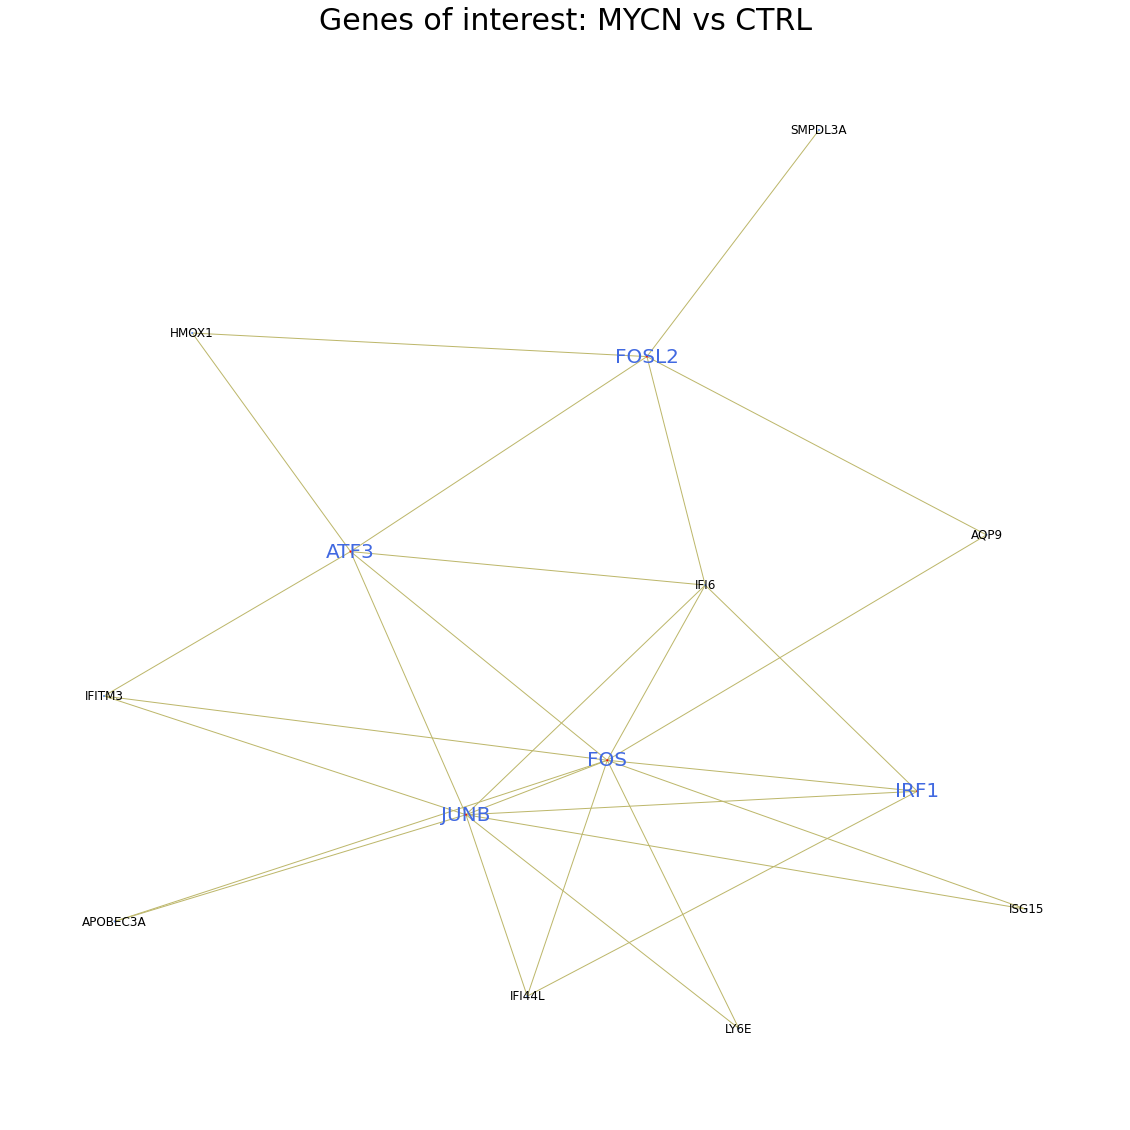

In [23]:
draw_save_network(
    sub_net_mycn, 
    nodes_motif_PG, 
    goi_mvsc, 
    'M_vs_C', 
    'Genes of interest: MYCN vs CTRL',
    "Graph_myeloid_mycn_vs_ctrl_starts.svg",
    'darkkhaki', 'royalblue', 'khaki'
)

In [24]:
sub_net_sporadic = goi_node_neighbors(PG, goi_svsc, nodes_motif_PG) #nx.Graph(test_sub)
sub_net_sporadic.remove_nodes_from(list(nx.isolates(sub_net_sporadic)))

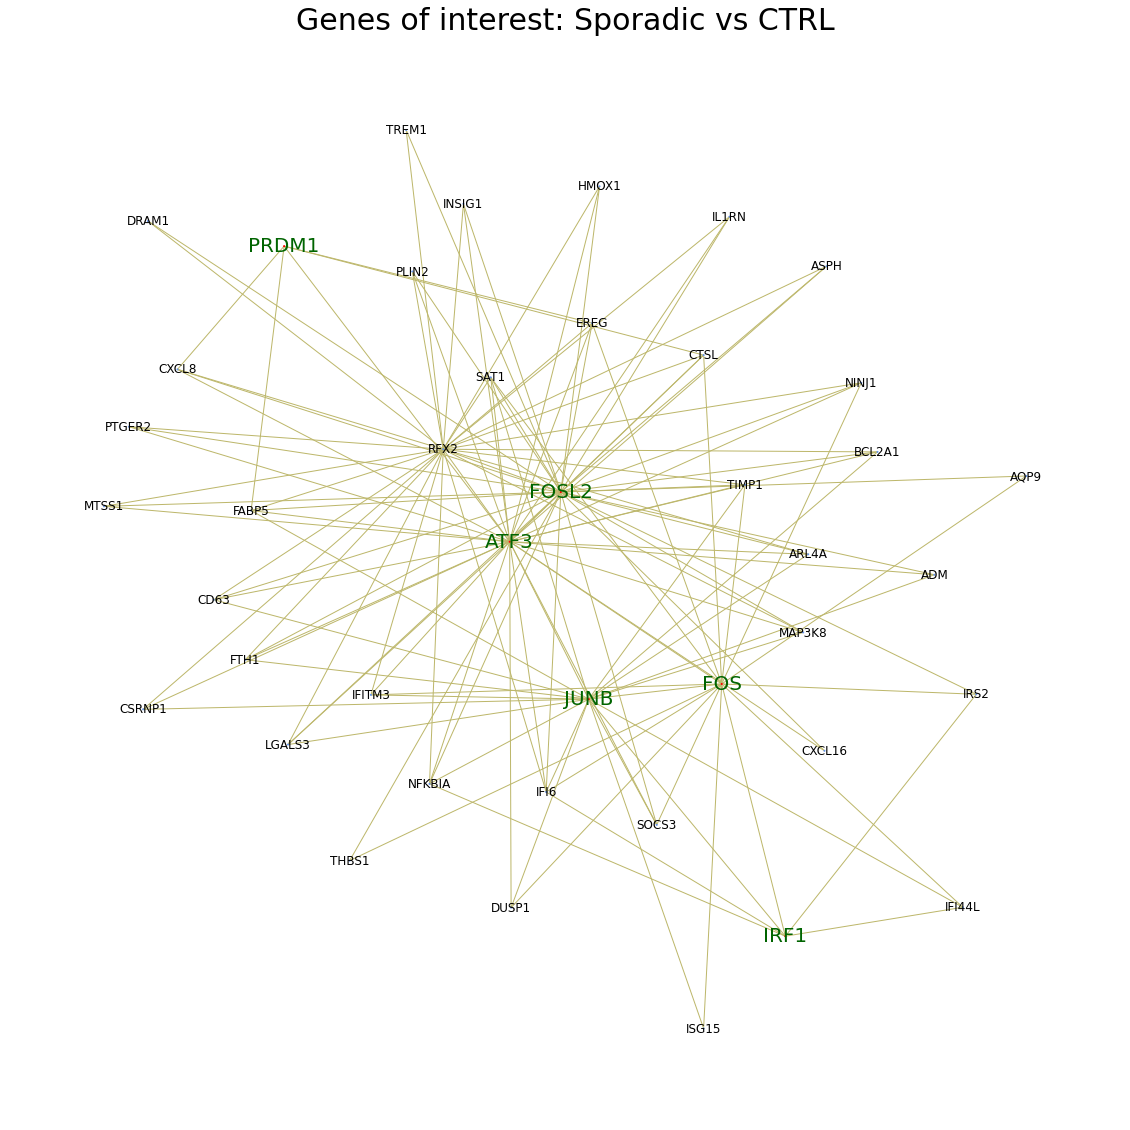

In [25]:
draw_save_network(
    sub_net_sporadic, 
    nodes_motif_PG, 
    goi_svsc, 
    'S_vs_C', 
    'Genes of interest: Sporadic vs CTRL',
    "Graph_myeloid_sporadic_vs_ctrl_starts.svg",
    'darkkhaki', 'darkgreen', 'khaki'
)

In [26]:
sub_net_atrx = goi_node_neighbors(PG, goi_avsc, nodes_motif_PG) #nx.Graph(test_sub)
sub_net_atrx.remove_nodes_from(list(nx.isolates(sub_net_atrx)))

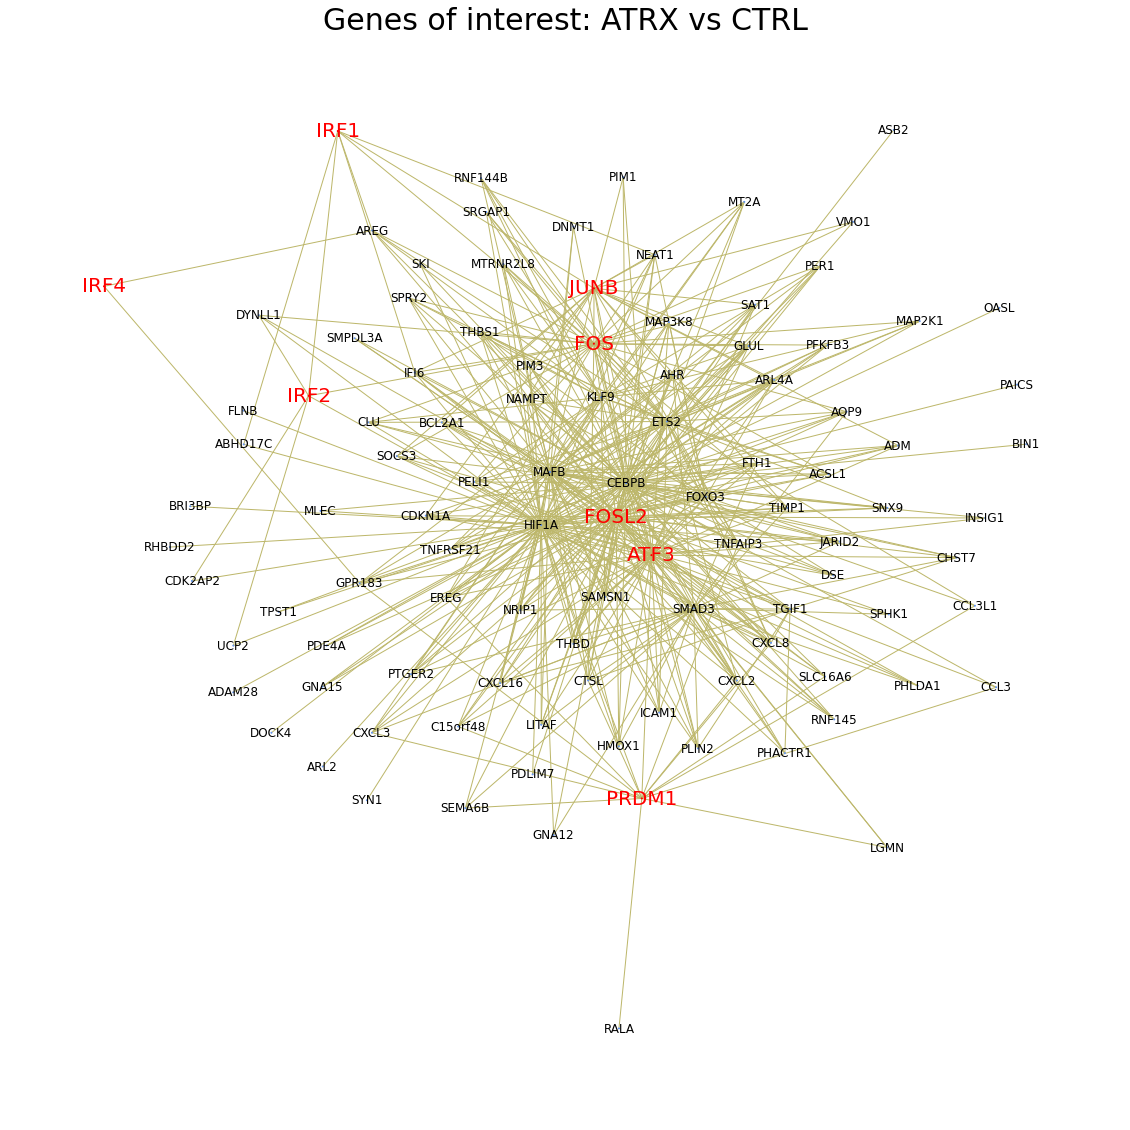

In [27]:
draw_save_network(
    sub_net_atrx, 
    nodes_motif_PG, 
    goi_avsc, 
    'A_vs_C', 
    'Genes of interest: ATRX vs CTRL',
    "Graph_myeloid_atrx_vs_ctrl_starts.svg",
    'darkkhaki', 'red', 'khaki'
)

In [28]:
# import matplotlib.pyplot as plt
def draw_pruned_network(network, tf_list, nodes_motif_homer, pagerank_prob, goi, title, filename, color):
    fig = plt.figure(figsize=(20,20))
    ax = plt.subplot(111)
    pos = graphviz_layout(network)  
    overlap = {k: v for k, v in pos.items() if (k in tf_list and k in nodes_motif_homer) }
    pos_large = {k: v for k, v in pos.items() if (k in tf_list and k not in overlap )}
    pos_small = {k: v for k, v in pos.items() if k not in tf_list}
    pos_homer = {k: v for k, v in pos.items() if (k in nodes_motif_homer and k not in overlap)}
    pos_pagerank = {k: v for k, v in pos.items() if k in pagerank_prob}
    goi_point= {k: v for k, v in pos.items() if k in goi }
    ax.set_title(title, fontsize=24)
    nx.draw(network, pos, node_size=10,  edge_color='powderblue')#, width=weights)node_color=color,silver
    #nx.draw_networkx_labels(network.subgraph(pos_small), pos_small, font_size=10, font_color='gray')
    nx.draw_networkx_labels(network.subgraph(pos_large), pos_large, font_size=16, font_color='k')
    nx.draw_networkx_labels(network.subgraph(pos_homer), pos_homer, font_size=20, font_color='k')
    nx.draw_networkx_labels(grn.subgraph(goi_point), goi_point, font_size=16, font_color=color)
    nx.draw_networkx_labels(grn.subgraph(overlap), overlap, font_size=18, font_color='purple')
    plt.tight_layout()
    plt.savefig(filename, format="SVG")
    plt.show()

In [29]:
grn = scglue.genomics.read_ctx_grn("pruned_grn_myeloid_threshold100.csv")

In [33]:
pagerank_file = open("top_pagerank.txt", "r")
pagerank_lines = pagerank_file.readlines()
pagerank = [gene.strip() for gene in pagerank_lines]

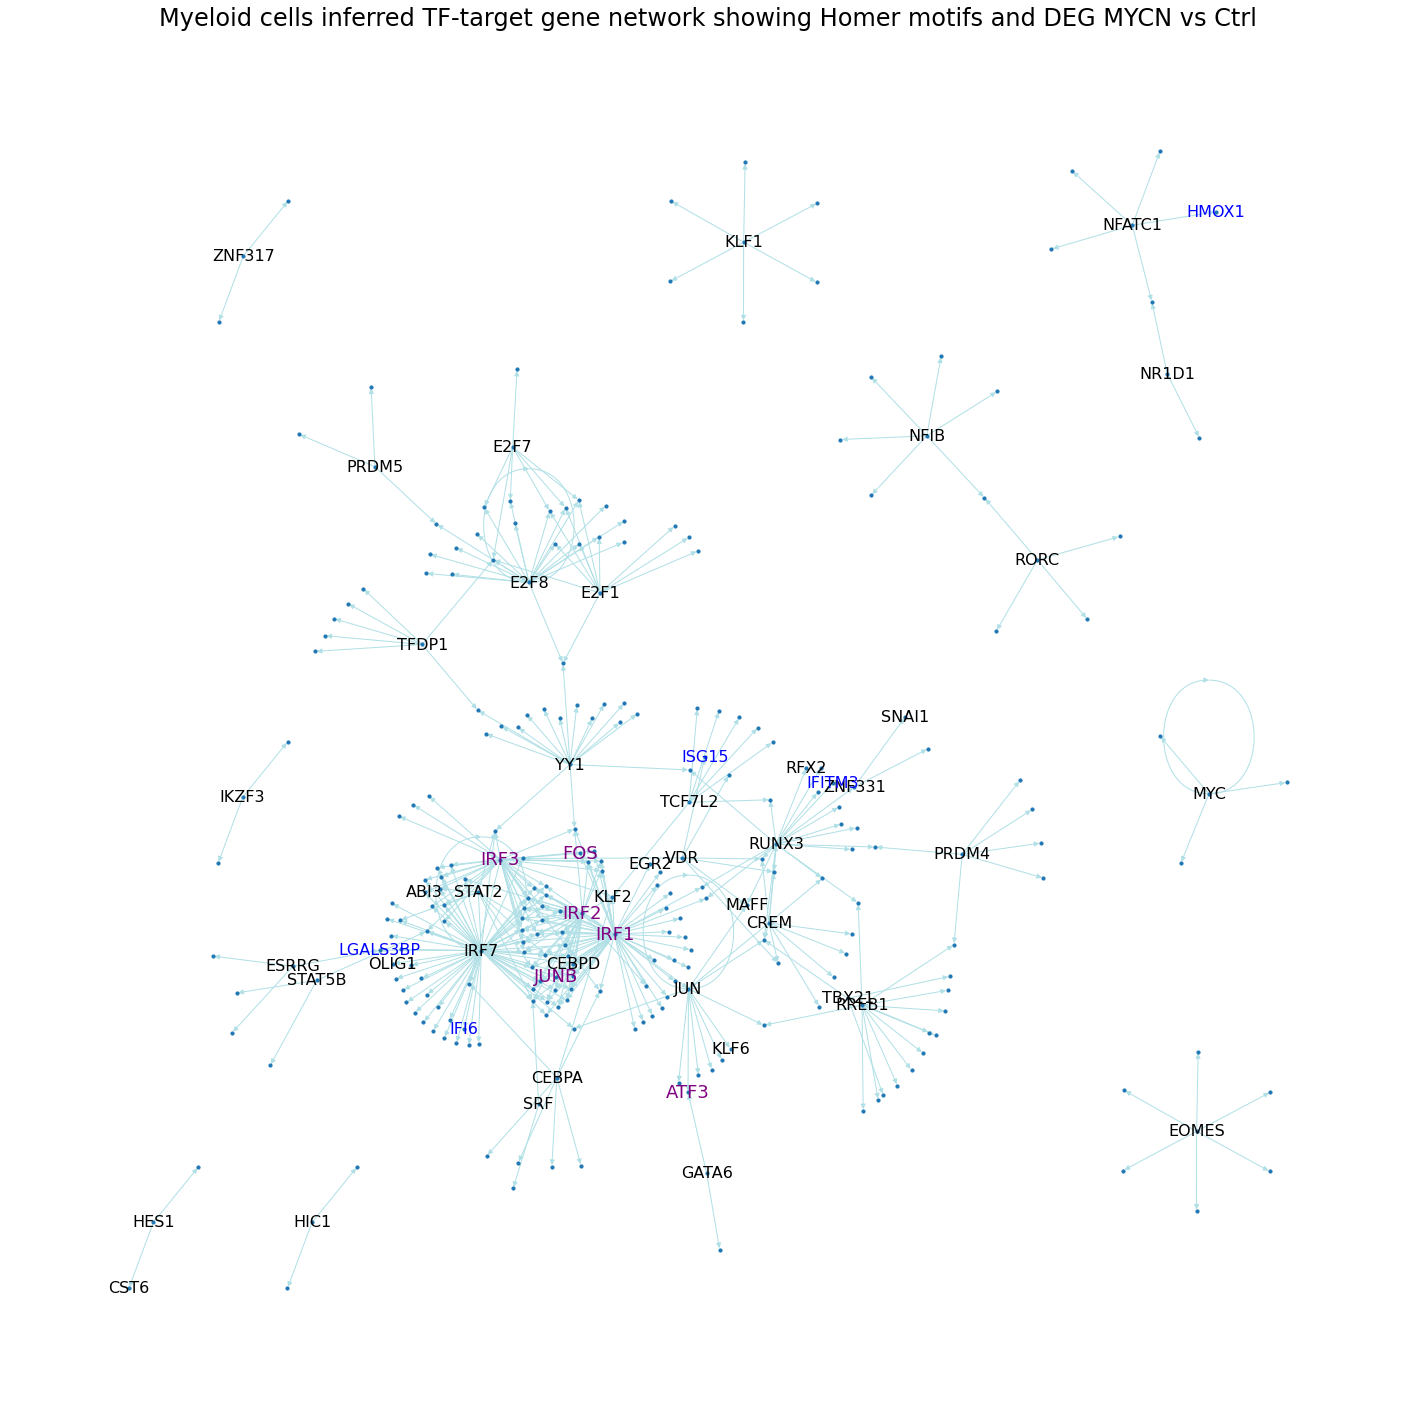

In [34]:
draw_pruned_network(
    grn, 
    tfs, 
    nodes_motif_PG,
    pagerank,
    goi_mvsc, 
    'Myeloid cells inferred TF-target gene network showing Homer motifs and DEG MYCN vs Ctrl',
    'Myeloid_pruned_network_homer_mvsc.svg',
    'blue')

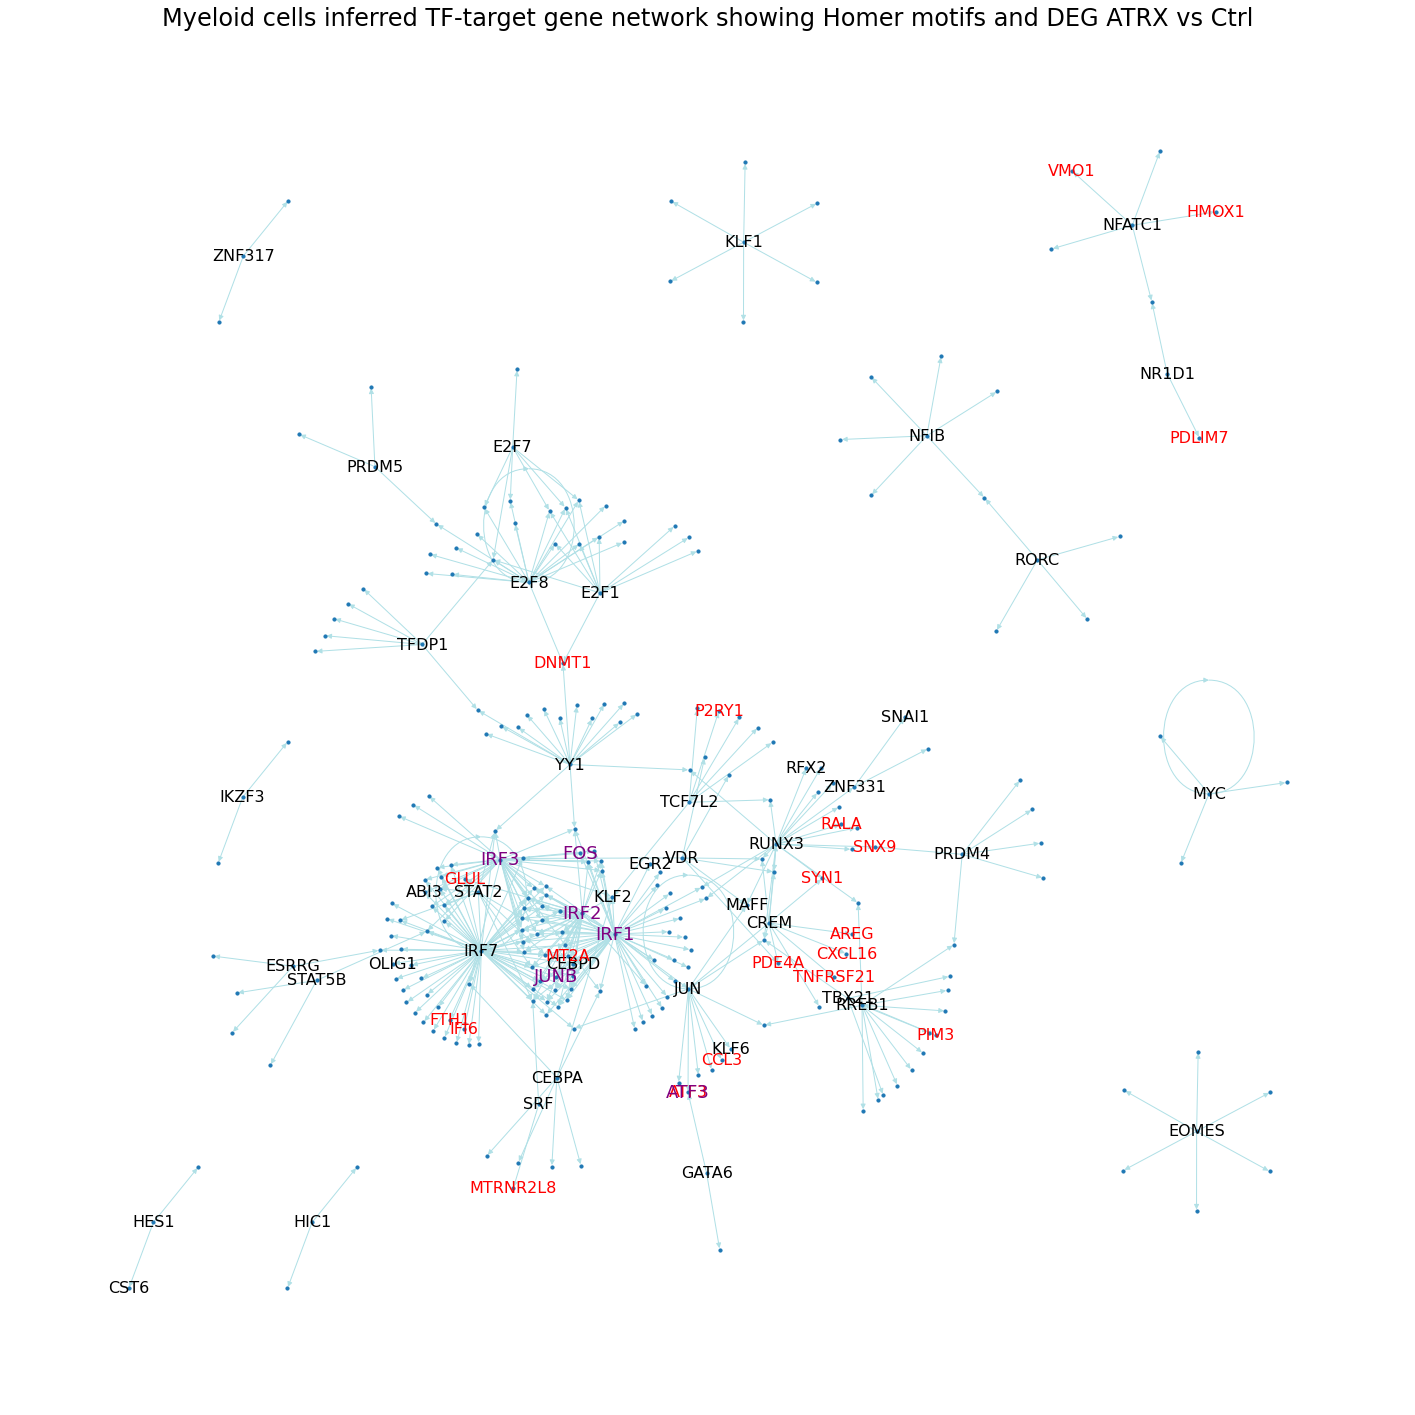

In [35]:
draw_pruned_network(
    grn, 
    tfs, 
    nodes_motif_PG,
    pagerank,
    goi_avsc, 
    'Myeloid cells inferred TF-target gene network showing Homer motifs and DEG ATRX vs Ctrl',
    'Myeloid_pruned_network_homer_avsc.svg',
    'red')

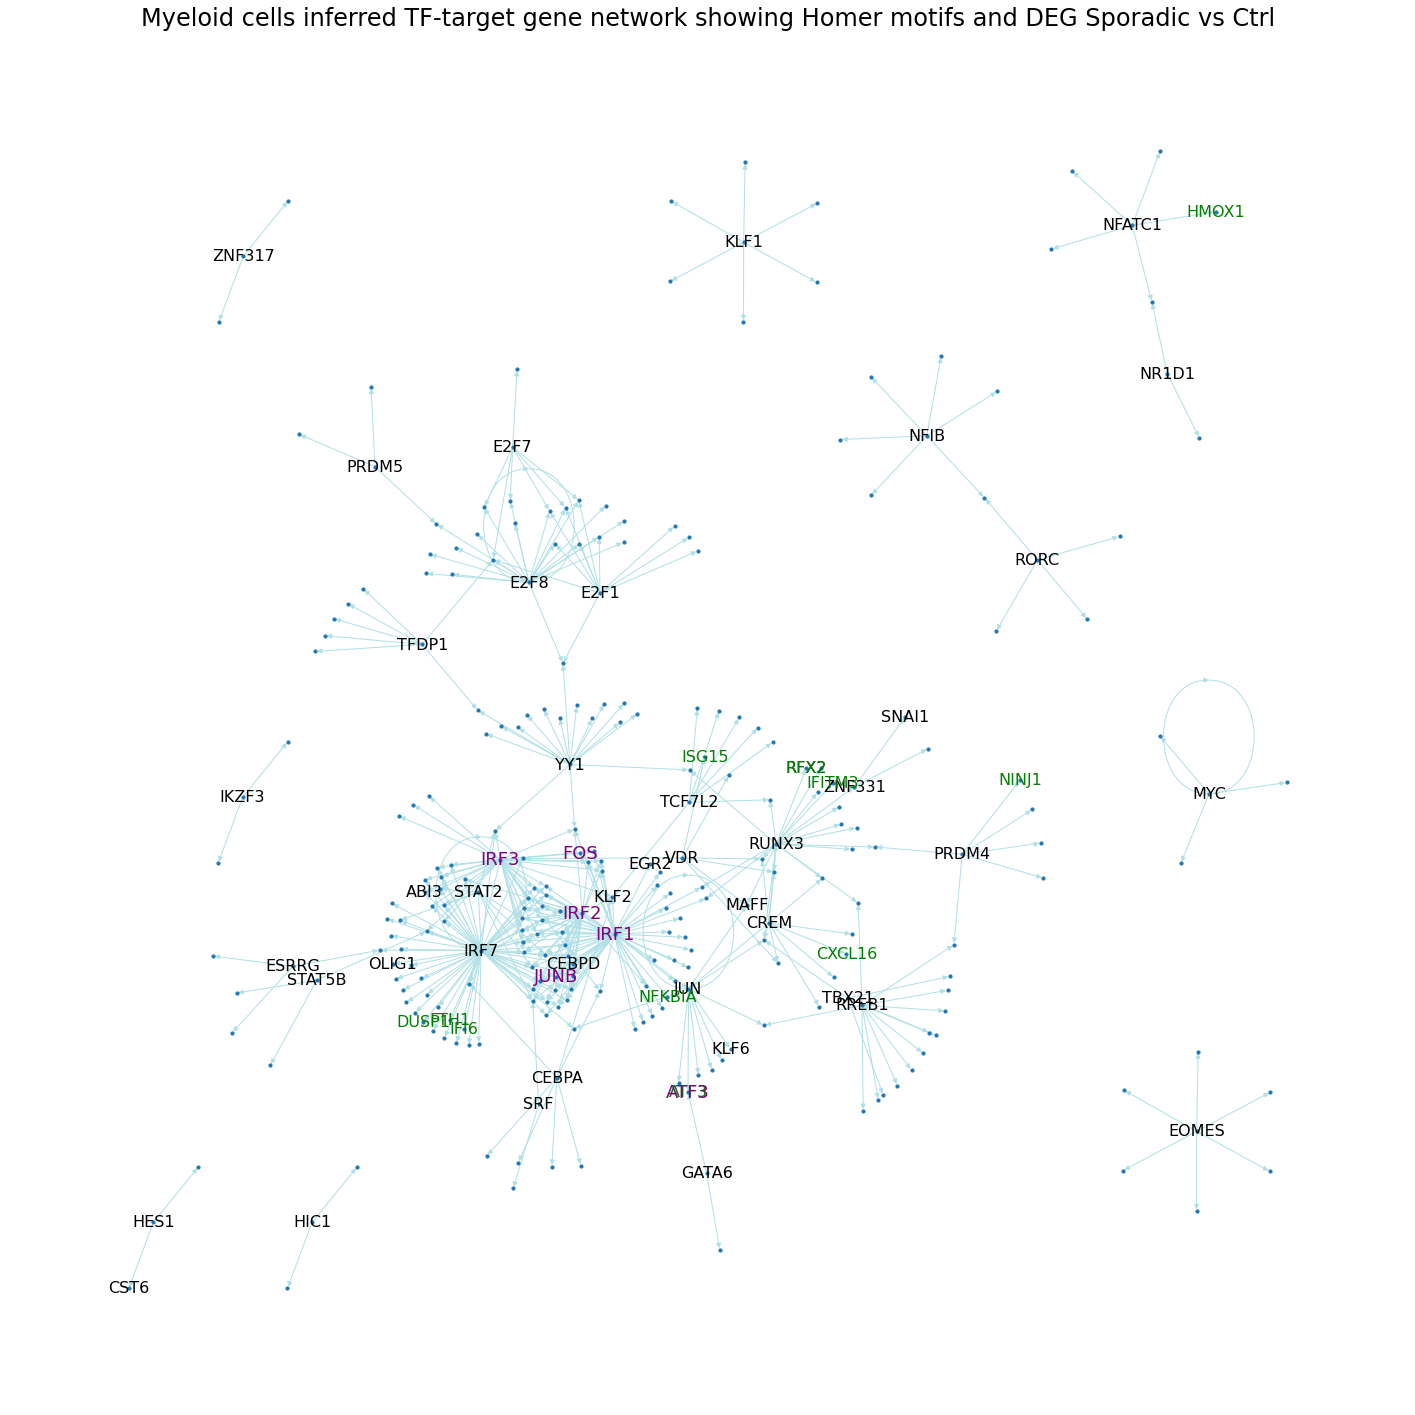

In [36]:
draw_pruned_network(
    grn, 
    tfs, 
    nodes_motif_PG,
    pagerank,
    goi_svsc, 
    'Myeloid cells inferred TF-target gene network showing Homer motifs and DEG Sporadic vs Ctrl',
    'Myeloid_pruned_network_homer_svsc.svg',
    'green')

## End!